# Ozone Time-Series Forecasting (1 to 4 stations)

# 1. METHODS
## Data handling & time-series split

Ozone sensor data points that were flagged as invalid were omitted entirely. Linear interpolation was used to fill in the missing values.

For the model selection, a unique form of k-fold cross-validation was used: **time-series split** (see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html ). In each split, shuffling is omitted, in order to retain the sequence of the full time-series. In addition, the model is trained with data of varying time-step length. The mean validation Mean Squared Error (MSE) determines whether a model is optimal and generalizes well. The "test" data is held-out from the start, never used in model selection.
![title](pics/timeSeriesValidateSplit.png)
In the experiments below, time-series split had 10-folds and the hold-out test data was the last year (2010, 365 days).

## Neuroevolution using "Island Speciation"

Neuroevolution is an algorithmic method that utilizes *Evolutionary Algorithms (EA)* to generate Artificial Neural Network (ANN) parameters, topologies and rules (see: https://en.wikipedia.org/wiki/Neuroevolution ). In order to find an optimal deep learning model for the time-series forecasting task, architecture search is performed in conjunction with hyper-parameter tuning. With **island speciation**, neuroevolution can be parallelized: Each island can be a distinct thread, process or even a different computing node. Even though the evolution progresses distinctly in each island, populations of meta-learning agents migrate periodically between islands.

Every island can have the same global optimization technique (with similar or different settings versus the other islands), a **species**. A global optimizer like Differential Evolution (DE) (see: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.optimize.differential_evolution.html ), maintains a number of different agents internally, that are used in a parameter search. An agent has a different internal representation (*genotype*) depending on the meta-heuristic algorithm. The actual bounded parameter set, the *phenotype*, is a candidate Deep Neural Network (DNN) model architecture that we try to optimize. Within the DE implementation, there exist 2-way operations that can perform genotype-to-phenotype representation conversions and vice-versa.

Three types of global optimization EA islands were used:
- **Random (Rand)** island. Creates a random model, by sampling the bounded hyper-parameter values from a uniform pseudo-random number generator. In this case genotype = phenotype and the island population is 1.

- **Differential Evolution** island. Genotype: energy (real values in [0,1]). Phenotype: the genotype values, scaled from [0, 1] into the bounds of each parameter.
![Alt Text](https://upload.wikimedia.org/wikipedia/commons/e/e0/Ackley.gif)
*Figure: Example of Differential Evolution optimizing the 2D Ackley function using a population of size 20 (source: https://en.wikipedia.org/wiki/Differential_evolution#/media/File:Ackley.gif ).*


- **Particle Swarm Optimization (PSO)** island (see: https://pythonhosted.org/pyswarm/ ). Genotype: position (multi-dimensional representation of the parameters as real values) and velocity (rate of change of the positions).
![Alt Text](https://upload.wikimedia.org/wikipedia/commons/e/ec/ParticleSwarmArrowsAnimation.gif)
*Figure: A particle swarm searching for the global minimum of a function (source: https://en.wikipedia.org/wiki/Particle_swarm_optimization#/media/File:ParticleSwarmArrowsAnimation.gif ).*


In some cases, it is possible to convert an agent from one global optimization method to another. For example, to convert a DE to a PSO agent: the agent of the DE "species" is converted from the DE genotype to the common phenotype (by unscaling real values) and then is converted to the PSO genotype (real values = position & velocity). We define this conversion process as **agent speciation**. Speciation in conjunction with the island model, allow combination (via *migration*) and diversification (via unique evolution per island) of different model architecture search methods.

Worth noting is that in order to keep the populations stable on all islands, the migrating agents replace a random agent at the receiving island. In practice, it was a matter of replacing an agent entry on the internal data structures of the EA algorithms. For the local experiments, the island population was fixed to 5 agents.

![title](pics/agentIslandSpeciation.png)

## Architecture search genes

The genes are expressed as bounded real or integer values. They can represent:
- Cells/layers of a sequential DNN.
- Various model hyper-parameters/rates.
- Training optimizers.

### Cell Sequence search

The candidate models contain 4 base layers:
- 3x Long-Short Term Memory (**LSTM**).
- 1x **Fully Connected** cell at the end.

The **auxiliary/utility cells** are placed between the base layers. Auxiliary cells placements are determined purely by the evolutionary search process.

![title](pics/cells.png)

### Hyper-Parameter search

The following **bounded parameters** (ranges expressed in the parentheses) are searched:
- Standard Deviation of the Gaussian noise.
- Dropout/Recurrent-dropout rate: Fraction of neurons to randomly ignore while training; reduces overfitting.
- Cell/layer size.
- Max training epochs.
- Batch size per epoch.




![title](pics/hyperParameters.png)

### Optimizer search

**Optimizers** are the algorithms that guide the weight training process of an ANN. The following optimizer options are possible (https://keras.io/optimizers/):
![title](pics/optimizers.png)

It is a subset of the total optimizers available, the only valid options for Recurrent Neural Networks (RNN).

### Overfitting avoidance

**Early Stopping** and **Learning-Rate reduction on plateau** (see: https://keras.io/callbacks/ ) use the *loss* and *validation_loss* values of Mean Squared Error (MSE) during training, to approach a finely-trained model and to avoid overfitting.

### Parallelism
An asynchronous version of the **Master-Slave pattern** (see: http://www.cs.sjsu.edu/~pearce/modules/patterns/distArch/master.htm ) allowed for CPU and GPU parallelism of different island species. Agent migration is carried out by slaves (islands) sending candidates to the master (main CPU process). The master decides when and to which island to migrate an agent. **Message Passing Interface (MPI)** handles the communication between the islands and the master (see: https://mpi4py.readthedocs.io/en/stable/tutorial.html#point-to-point-communication ).

The parallel implementation was tested on a local workstation (6 physical CPU cores, 2x Cuda capable GPUs), as well as on the Amazon Elastic Compute Cloud (EC2), on a p3.8xlarge Amazon Machine Image (AMI) (see: https://aws.amazon.com/ec2/instance-types/p3/ ) containing 4x Tesla V100 GPUs (*note: unfortunately, for now, the models/weights trained on the cloud are incompatible with the local tensorflow installation*). After the completion of the "Python for HPC" seminar, the GPU cluster of the VSC super-computer will be utilized (see: https://www.vscentrum.be/ ).

# 2. MODELS & RESULTS
## Naive method, using the previous step (Naive-1)

The Naive-1 method is the simplest forecasting model, which can serve as a benchmark against the more sophisticated methods.

Loading of all the raw ozone sensor values from CSV (2000-2010, station BETN0073 in Belgium):

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

station = "BETN073"
modelLabel = "rand"

dataManipulation = {
    "detrend": False,
    "scale": None,
#     "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)
y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

### Naive-1 prediction & metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) # In %
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %

year = 2010
lag = 1
data = r[-365:,0]
ts_lag1 = r[-365:,52]

MSE = mean_squared_error(data, ts_lag1)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(data, ts_lag1)
MAPE = mean_absolute_percentage_error(data, ts_lag1)
SMAPE = smape(data, ts_lag1)
R2_score = r2_score(data, ts_lag1)
IOA = 1 - (np.sum((data - ts_lag1) ** 2)) / (np.sum(
    (np.abs(ts_lag1 - np.mean(data)) + np.abs(data - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Naive-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(data)
pyplot.plot(ts_lag1)
ax.legend(['expected', 'predicted'])

Metric Abbreviations:
- MSE: Mean Squared Error
- MAPE: Mean Absolute Percentage Error
- SMAPE: Symmetric Mean Absolute Percentage Error
- IoA: Index of Agreement

## Naive LSTM Multiple-Input Single-Output (MISO) Nonlinear AutoRegressive eXogenous model with lag of 1 day (NARX-1)

The Naive LSTM model, is one of the simplest recurrent models possible: uses a single LSTM layer and 1 fully connected layer at the end. The typical Recurrent Neural Network (RNN) and Gated Recurrent Unit (GRU) layer options on this simple architecture were dropped, due to inferior performance (see: https://keras.io/layers/recurrent/ ), with Mean Absolute Percentage Error (MAPE) ~ 65%, much worse than the Naive-1 baseline.

Loading of the standardized data (1 sensor prediction + 51 weather variables):

In [ ]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
#     "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 50000,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts

row2000_01_01 = 3653 - 1
row2010_12_31 = 7670
r = r[row2000_01_01:row2010_12_31,:]
print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 1
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)
print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

from __future__ import print_function
import numpy as np
from keras.models import model_from_json
import pandas as pd

json_file = open('runs/naiveLstm/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/naiveLstm/foundModels/bestModelWeights.h5")

Naive LSTM model:
- 1x Bi-directional Long-Short Term Memory (LSTM) cell of size 64 with 1 dense layer at the end:
![title](runs/naiveLstm/foundModels/deModelIter1.png)

In [ ]:
sensor_mean = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_mean.pkl")
sensor_std = pd.read_pickle("data/4stations51vars/BETN_12_66_73_121_51vars_O3_O3-1_19900101To2000101_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

In [ ]:
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
    (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Naive LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])

## Deep LSTM MISO NARX-1

The Deep LSTM MISO models use a sequence architecture of:
- 3x Bidirectional LSTM base cells.
- 1-3x Gaussian Noise and/or Batch Normalization auxiliary cells.

Two model versions were used in the experiments:
- Trained with 10 years of data (training: 2000-2009, testing: 2010).
-  Trained with 20 years of data (training: 1990-2009, testing: 2010). The chosen stations (BETN022, BETN066, BETN07e, BETN122) were some of the few that had data since 1990, but they were many weeks or even months of missing data in the first years.

### 10 years training, 1 year testing

Loading of the model (best chosen after 15 island search iterations):

In [ ]:
json_file = open('runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuPsoDe1stationNarx1_10years/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 gaussian noise cell:
![title](runs/2gpuPsoDe1stationNarx1_10years/foundModels/deModelIter1.png)

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

prediction = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validation = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = smape(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
    (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (Station: {}) {}: Deep LSTM MISO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(station, year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected', 'predicted'])

## Summary (MISO - 1 ozone station)

All the models except the last, use 10 years of data (station BETN0073): 2000-2009 for training and 2010 for testing. The LSTM models use 51 weather variables, gathered from the surface-level ERA-interim ECMWF database (see: https://apps.ecmwf.int/datasets/data/interim-full-daily/levtype=sfc/ ). We can see that the *Naive LSTM NARX-1* model, with a lag of 1 day has slightly lower MSE and better Index of Agreement (IoA) versus the Fixed-Size Least Squares Support Vector Machine (*FS-LSSVM*). The downside was the longer training time (~5 minutes) compared to the kernel-based approach, and the Mean Absolute Percentage Error (MAPE) was ~5.38% higher, signigicantly worse. Training time was even more substantial for the **Deep LSTM NARX-1** (~18 minutes, using the full island speciation process), but we can see that it achieves the best performance for the 10-year dataset: MAPE below 25%, IoA at 95% and MSE significantly  lower than the other methods.

*Note: The data for Value NAR-1, LSSVM NARX and FS-LSSVN models were gathered from the previous thesis on ozone modelling [1, 2]. Unfortunately, there was no direct mention on the related section about the exogenous variables used. For the LSTM methods, all the 51 valid weather time-series were utilized.*

|Metric| Naive-1 | Value NAR-1 | LSSVM NARX | FS-LSSVM NARX | Naive LSTM NARX-1 | Deep LSTM NARX-1
|------|------|------|------|------|------|------|
|   **MSE**  | 312.15 | 281.685| 241.045 | 163.467| 160.34 | **135.48**
|   **MAPE** | 35.42% | 37.8% | 51.2% | 25.8% |31.18% | **23.56%**
|   **SMAPE**  | 26.66% | - | - | - | 20.3% | **19.25%**
|   **IoA**  | 89.48% | 88.6% | 93.2% | 94.6%| 93.39% | **95.14%**

# Multiple-Input Multiple-Output (MIMO) NARX-1 for 24 stations (All Belgian rural background)

## Random model search

Two non-communicating random search islands generated random candidate DNN models. After several iterations, the one with the minimum average validation MSE was kept.

Reading of the standardized dataset (4 sensors prediction, training: 1990-2010, testing: 2011):

In [8]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot

modelLabel = 'rand'

dataManipulation = {
    "detrend": False,
    # "scale": None,
    "scale": 'standardize',
    # "scale": 'normalize',
    "swapEvery": 5,  # Do swap island agent every iterations
    "master": 0,
    "folds": 10,
    "iterations": 40,
    "agents": 5
}

year = 2011
lag = 1
    
print('Loading data...')

print('Using scale: {}'.format(dataManipulation["scale"]))

if dataManipulation["scale"] == 'standardize':
    r = np.genfromtxt("data/24stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To2000101_ts_standardized.csv", delimiter=',')
elif dataManipulation["scale"] == 'normalize':
    r = np.genfromtxt("data/24stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To2000101_ts_normalized.csv", delimiter=',')
else:
    r = np.genfromtxt("data/24stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To2000101_ts.csv", delimiter=',')
r = np.delete(r, [0], axis=1)  # Remove dates

print('r shape:', r.shape)

print("\nStart Array r:\n {}".format(r[0, 0]))

maxLen = r.shape[1] - 1
print('Variables: {}'.format(maxLen))
print('TimeSteps: {}'.format(r.shape[0]))

mimoOutputs = 24
x_data = r[:, mimoOutputs:maxLen + 1]
y_data = r[:, 0:mimoOutputs]

print('x_data shape:', x_data.shape)

print("y_data shape:", y_data.shape)

y_data = np.array(y_data)
x_data_3d = x_data.reshape(x_data.shape[0], 1, x_data.shape[1])  # reshape input to 3D[samples, timesteps, features]

Loading data...
Using scale: standardize
r shape: (8035, 99)

Start Array r:
 -1.7021692176284458
Variables: 98
TimeSteps: 8035
x_data shape: (8035, 75)
y_data shape: (8035, 24)


Loading of  the model:

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only for inference

from __future__ import print_function
import numpy as np
from keras.models import model_from_json
import pandas as pd

json_file = open('foundModels/bestModelArchitecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells  with 1 gaussian noise cell:
![title](runs/2gpuRand4stationsNarx1/foundModels/randModelIter3.png)

Sample training history plot (for last fold only, training: 1990-2009, validation: 2010):
![title](runs/2gpuRand4stationsNarx1/foundModels/randIter3History.png)

In [10]:
x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
y_data, y_data_holdout = y_data[:-365], y_data[-365:]

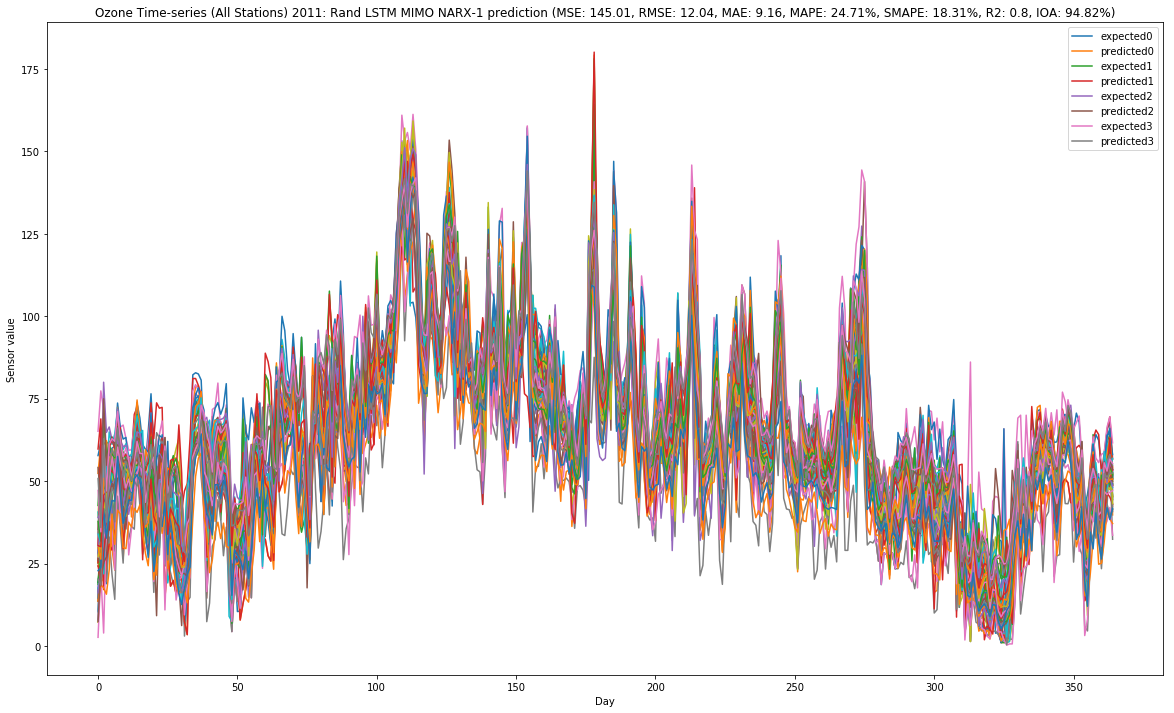

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))) # In %
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # In %
def index_of_agreement(validation, prediction):
    return 1 - (np.sum((validation - prediction) ** 2)) / (np.sum((np.abs(prediction - np.mean(validation)) + np.abs(validation - np.mean(validation))) ** 2))

holdout_prediction = loaded_model.predict(x_data_holdout)

sensor_mean = pd.read_pickle("data/24stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To2000101_ts_mean.pkl")
sensor_std = pd.read_pickle("data/24stations51vars/ALL_BETN_51vars_O3_O3-1_19900101To2000101_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All Stations) {}: Rand LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected0', 'predicted0', 'expected1', 'predicted1', 'expected2', 'predicted2', 'expected3', 'predicted3'])    


Text(0.5,0,'Day')

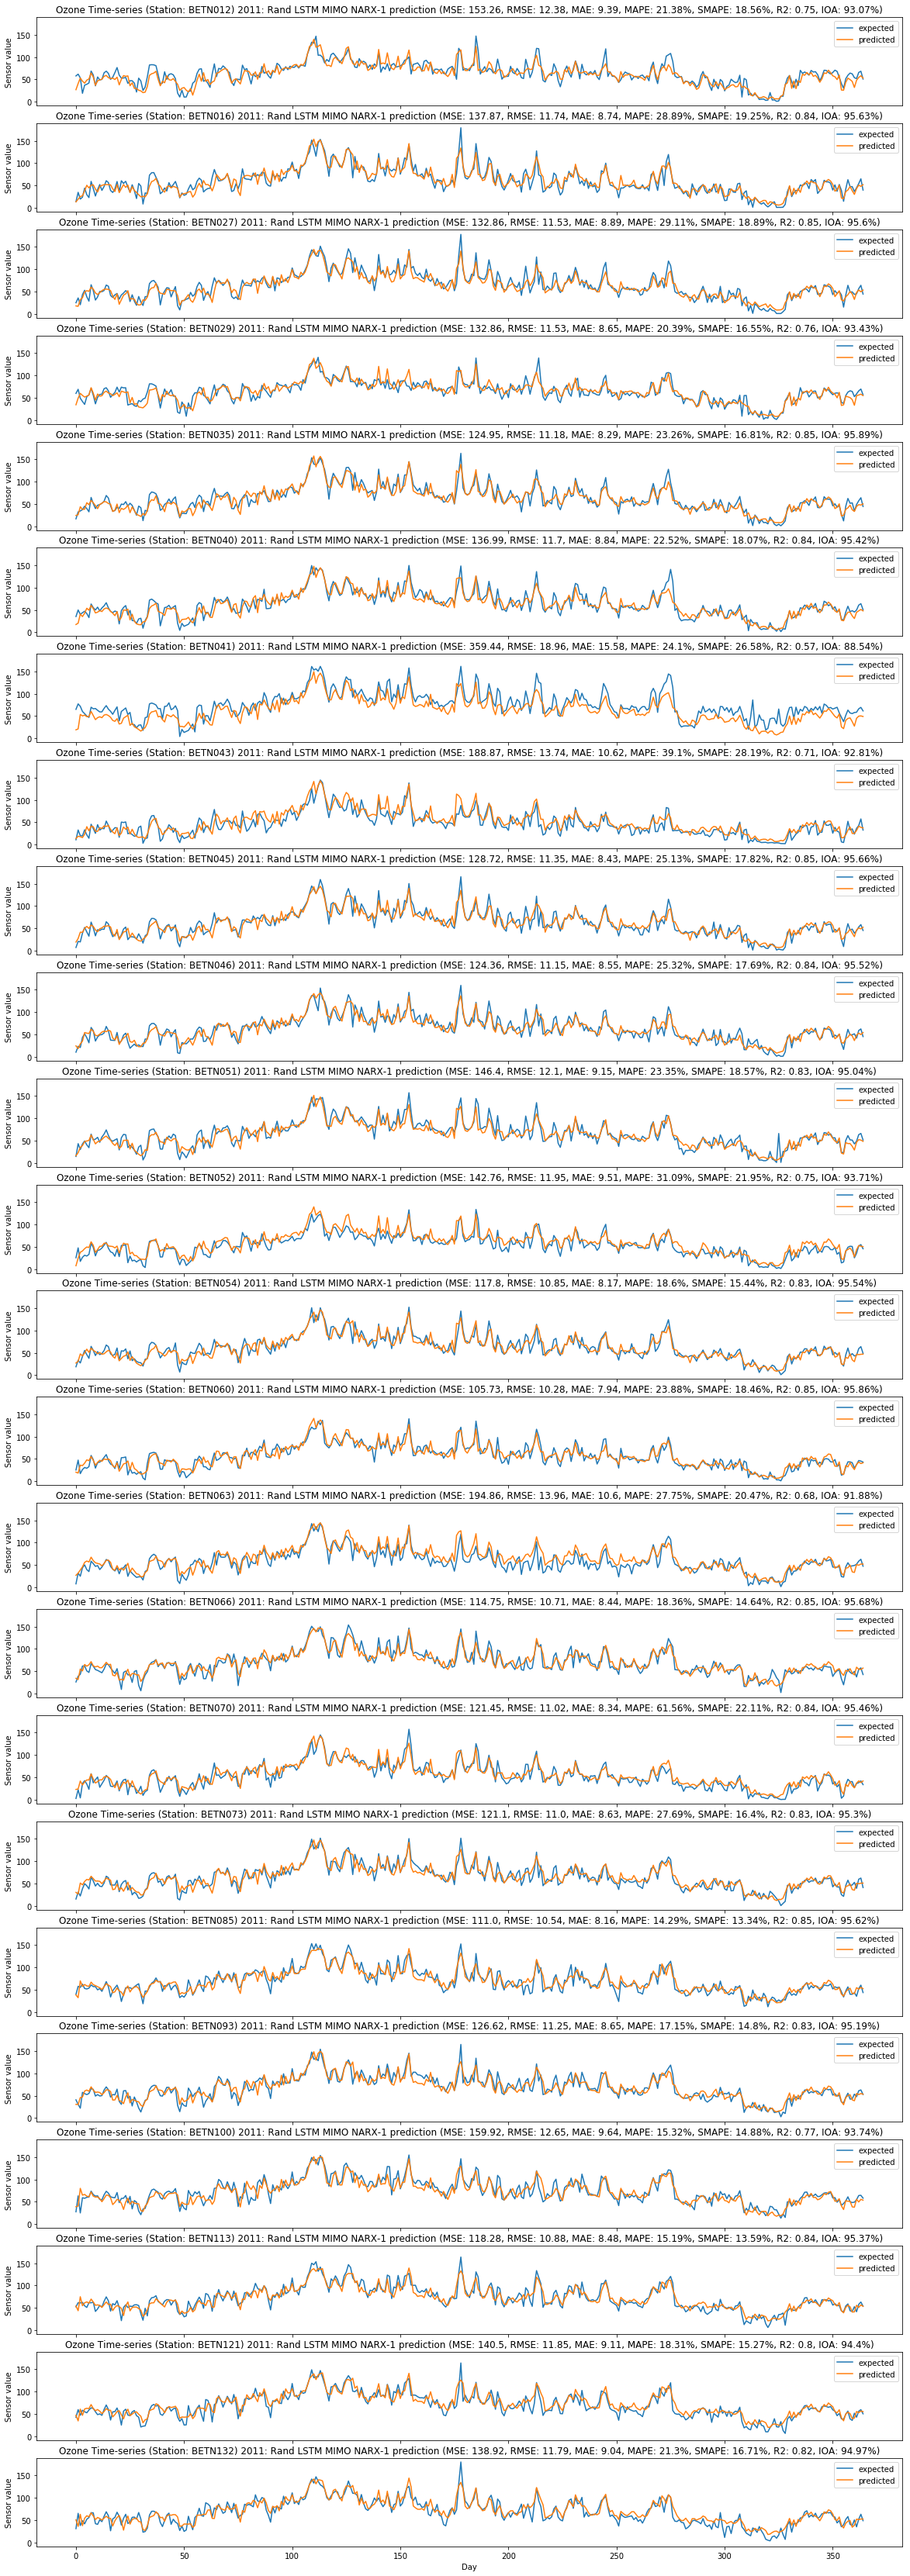

In [29]:
stations = ["BETN012", "BETN016", "BETN027", "BETN029", "BETN035", "BETN040", "BETN041", 
            "BETN043", "BETN045", "BETN046", "BETN051", "BETN052", "BETN054", "BETN060", 
            "BETN063", "BETN066", "BETN070", "BETN073", "BETN085", "BETN093", "BETN100", 
            "BETN113", "BETN121", "BETN132"]
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 60), sharex=True, sharey=True)

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)
    ax[i].set_ylabel('Sensor value')
#     ax[i].set_xlabel('Day')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Rand LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])    
    ax[i].legend(['expected', 'predicted'])
ax[i].set_xlabel('Day')

## Summary (MIMO - 24 background rural ozone stations)

|Metric| Islands LSTM NARX-1 |
|------|------|
|   **MSE**  | 145.01 |
|   **MAPE** | 24.71% |
|   **SMAPE** | 18.31% | 
|   **IoA**  | 94.82% |

## Neuroevolution using "Island Speciation"

Loading of the model:

In [ ]:
json_file = open('runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/bestModelWeights.h5")

Model shape:
- 3 stacked Bi-directional Long-Short Term Memory (LSTM) cells with 1 batch normalization cell:
![title](runs/2gpuPsoDe5agents40iters2islandsEvery10/foundModels/deModelIter13.png)

In [ ]:
holdout_prediction = loaded_model.predict(x_data_holdout)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
   
prediction = predictionAll
y_validation = y_validationAll

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
# SMAPE = smape(prediction, prediction)
SMAPE = ( smape(y_validation[:,0], prediction[:,0]) + smape(y_validation[:,1], prediction[:,1]) + smape(y_validation[:,2], prediction[:,2]) + smape(y_validation[:,3], prediction[:,3])) / 4.0
R2_score = r2_score(y_validation, prediction)
IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
    (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(16, 12), sharex=True, sharey=True)
ax.set_ylabel('Sensor value')
ax.set_xlabel('Day')
ax.set_title('Ozone Time-series (All Stations) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
pyplot.plot(y_validation)
pyplot.plot(prediction)
ax.legend(['expected0', 'predicted0', 'expected1', 'predicted1', 'expected2', 'predicted2', 'expected3', 'predicted3'])    


In [ ]:
fig, ax = pyplot.subplots(nrows=4, ncols=1, figsize=(18, 32), sharex=True, sharey=True)
stations = ["BETN022", "BETN066", "BETN073", "BETN122"]

for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    SMAPE = smape(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = 1 - (np.sum((y_validation - prediction) ** 2)) / (np.sum(
        (np.abs(prediction - np.mean(y_validation)) + np.abs(y_validation - np.mean(data))) ** 2))
    ax[i].set_ylabel('Sensor value')
    ax[i].set_xlabel('Day')
    ax[i].set_title('Ozone Time-series (Station: {}) {}: Island LSTM MIMO NARX-{} prediction (MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, SMAPE: {}%, R2: {}, IOA: {}%)'.format(stations[i], year, lag, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(SMAPE,2), np.round(R2_score,2), np.round(IOA * 100,2)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])
    ax[i].legend(['expected', 'predicted'])

## Summary (MIMO - 4 ozone stations)
The table shows the average metrics of the Deep LSTM NARX-1 model, using Random and Island speciation architecture search: 

|Metric| Random LSTM NARX-1 | Islands LSTM NARX-1 |
|------|------|------|
|   **MSE**  | 128.33 | **124.58** |
|   **MAPE** | **20.45%** | 20.58% |
|   **SMAPE**  | 15.91% | **15.6%** | 
|   **IoA**  | 95.19% | **95.2%** |

The *random search* method, found the best model on the 3rd iteration, out of 13 iterations total.

The *Island Speciation* performed: 113 PSO and 70 DE iterations, migrating an agent every 5 iterations.

Even though the island model performed 183 combined iterations, the best model was found early, on the 13th DE iteration. This potentially shows that the architecture search-space is rather small: currently only deep neural networks with 3x LSTM and 1x Dense cells are allowed in the genotype. Both DE and PSO had 5 agents and used the default parameters. DE has enabled the "Latin hypercube" instead of the "random" option for the initial agent genotypes. The only non-default option for DE was the mutation strategy: dispatching was done via "best2exp" (exponential) versus the default "best1bin" (binomial). In addition, for future experiments, more iterations (300+) will be allowed.

### References:
1. J. Orellana Alvear. Application of LS-SVMs to ozone forecasting in Belgium, 2015.
2. Denis Dumoulin. Fixed-Size Multi-Output LSSVM for Nonlinear System Identification, 2017.